# Pipeline 1: predicting missing values for activity

## Section 1: Loading event log

In [58]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
from google.colab import auth
auth.authenticate_user()

In [60]:
from google.cloud import bigquery
client = bigquery.Client(project='processmining-367815')

In [106]:
import requests

# read a query from the github repository
# change depending on which branch the queries have been pushed to
branch = "sql-queries" 
# change this to change which query is being used
query_name = "event_log_mvp.sql"
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{branch}/sql_queries/{query_name}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

In [107]:
import pandas as pd

# loading event log from bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,105764,Transfer,2134-03-01 00:38:40
1,112013,Transfer,2187-02-12 00:42:40
2,150193,Transfer,2192-06-01 01:13:39
3,144980,Transfer,2169-08-14 00:30:19
4,122192,Transfer,2120-04-15 00:32:00
...,...,...,...
140355,109352,Discharged,2167-04-16 17:10:00
140356,166032,Discharged,2198-09-20 21:16:00
140357,120514,Discharged,2163-09-09 17:30:00
140358,175280,Discharged,2204-01-25 14:20:00


## Section 2: process mining

In [108]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-108-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')


Number of cases: 42652
Number of events: 140360
Start events: {'Admitted': 36389, 'Transfer': 6208, 'Discharged': 55}
End events: {'Discharged': 42563, 'Transfer': 85, 'Admitted': 4}


In [116]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [111]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

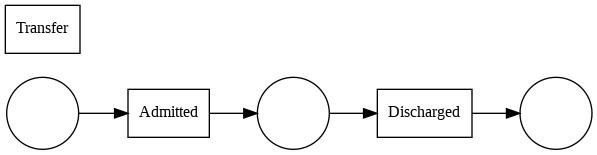

In [112]:
import graphviz
pm.view_petri_net(petri_net=net)

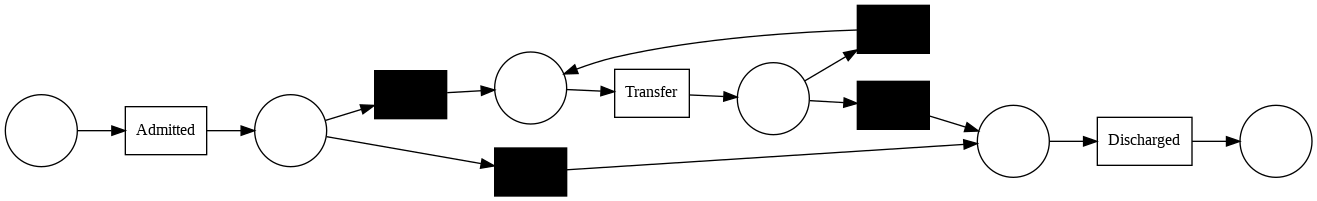

In [113]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

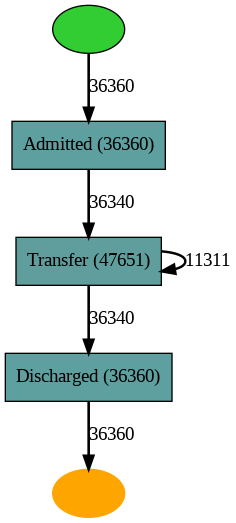

In [114]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

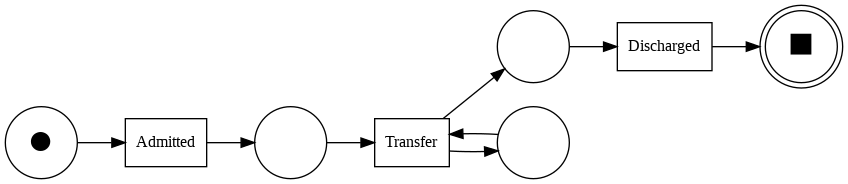

In [115]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Predicting Missing Activities

In [125]:
import random
# select the first 100 cases to test the LSTM methodology
# lets first add a trace column to the event_log
event_log['trace'] = event_log.groupby(['patient']).ngroup()

# we can now select 100 random traces,
# this will be repeated with a a larger number of traces
# lets first initialise a random seed
random.seed(9)
num_traces = 100
random_traces = []

for i in range(0,num_traces):
  random_traces.append(random.randrange(0,n_cases))

partial_event_log = event_log[event_log['trace'].isin(random_traces)]

partial_event_log

,patient,activity,timestamp,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp,trace
973,100685,Admitted,2184-09-30 22:49:00,100685,Admitted,2184-09-30 22:49:00,973,291,2184-09-30 22:49:00,253
974,100685,Transfer,2184-09-30 22:51:07,100685,Transfer,2184-09-30 22:51:07,974,291,2184-09-30 22:51:07,253
975,100685,Discharged,2184-10-05 18:35:00,100685,Discharged,2184-10-05 18:35:00,975,291,2184-10-05 18:35:00,253
1316,100931,Admitted,2200-03-07 16:24:00,100931,Admitted,2200-03-07 16:24:00,1316,395,2200-03-07 16:24:00,345
1317,100931,Transfer,2200-03-07 16:25:01,100931,Transfer,2200-03-07 16:25:01,1317,395,2200-03-07 16:25:01,345
...,...,...,...,...,...,...,...,...,...,...
136595,197249,Transfer,2119-02-14 18:19:36,197249,Transfer,2119-02-14 18:19:36,136595,41506,2119-02-14 18:19:36,35374
136596,197249,Discharged,2119-02-21 17:45:00,197249,Discharged,2119-02-21 17:45:00,136596,41506,2119-02-21 17:45:00,35374
140230,199911,Admitted,2196-05-10 12:35:00,199911,Admitted,2196-05-10 12:35:00,140230,42611,2196-05-10 12:35:00,36324
140231,199911,Transfer,2196-05-10 12:36:03,199911,Transfer,2196-05-10 12:36:03,140231,42611,2196-05-10 12:36:03,36324


In [ ]:
# split event log into a train and test set
